In [80]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
import random

In [81]:
training_data=[]
DATADIR="/content/drive/My Drive/Dataset unzipped/Stage_2"
CATEGORIES=["Memes","Notes"]
def create_training_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR,category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            img_array=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
            training_data.append([img_array,class_num])
create_training_data()

1
(1520, 50, 50)
(1, 1520)
(40, 50, 50)
(1, 40)
(40, 50, 50)
(1, 40)


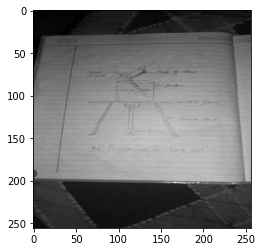

In [82]:
X_data=[]
Y_data=[]

for features,label in training_data:
  X_data.append(features)
  Y_data.append(label)


train_x_orig = np.concatenate((np.array(X_data[:760]),np.array(X_data[800:1560])))
train_y_orig = np.concatenate((np.array(Y_data[:760]),np.array(Y_data[800:1560])))
idx_train=np.random.permutation(1520)
train_x_orig, train_y_orig =train_x_orig[idx_train],train_y_orig[idx_train]

test_x_orig = np.concatenate((np.array(X_data[760:780]),np.array(X_data[1560:1580])))
test_y_orig = np.concatenate((np.array(Y_data[760:780]),np.array(Y_data[1560:1580])))
idx_test=np.random.permutation(40)
test_x_orig, test_y_orig =test_x_orig[idx_test],test_y_orig[idx_test]

val_x_orig = np.concatenate((np.array(X_data[780:800]),np.array(X_data[1580:1600])))
val_y_orig = np.concatenate((np.array(Y_data[780:800]),np.array(Y_data[1580:1600])))
idx_val=np.random.permutation(40)
val_x_orig, val_y_orig =val_x_orig[idx_val],val_y_orig[idx_val]



plt.imshow(train_x_orig[0],cmap='gray')
print(train_y_orig[0])

train_x_orig.resize((1520,50,50))
test_x_orig.resize((40,50,50))
val_x_orig.resize((40,50,50))


train_y_orig=np.reshape(train_y_orig,(1,-1))
test_y_orig=np.reshape(test_y_orig,(1,-1))
val_y_orig=np.reshape(val_y_orig,(1,-1))

print(train_x_orig.shape)
print(train_y_orig.shape)
print(val_x_orig.shape)
print(val_y_orig.shape)
print(test_x_orig.shape)
print(test_y_orig.shape)

In [83]:
m_train=train_x_orig.shape[0]
m_test=test_x_orig.shape[0]
m_val=val_x_orig.shape[0]
num_px=train_x_orig.shape[1]

print(m_train)
print(m_test)
print(m_val)
print(num_px)

1520
40
40
50


In [84]:
X_train_flatten=train_x_orig.reshape(train_x_orig.shape[0],-1).T
X_test_flatten=test_x_orig.reshape(test_x_orig.shape[0],-1).T
X_val_flatten= val_x_orig.reshape(test_x_orig.shape[0],-1).T

X_train=X_train_flatten/255
X_test=X_test_flatten/255
X_val=X_val_flatten/255

Y_train=train_y_orig
Y_test=test_y_orig
Y_val=val_y_orig

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(X_val.shape)
print(Y_val.shape)


(2500, 1520)
(1, 1520)
(2500, 40)
(1, 40)
(2500, 40)
(1, 40)


In [85]:
def random_mini_batch(X,Y,mini_batch_size=64):
  m=X.shape[1]
  minibatches=[]
  permutation = list(np.random.permutation(m))
  shuffled_X = X[:, permutation]
  shuffled_Y = Y[:, permutation].reshape((1,m))
  num_complete_mini_batches=math.floor(m/mini_batch_size)
  for k in range(0,num_complete_mini_batches):
    mini_batch_X=shuffled_X[:,k*mini_batch_size:mini_batch_size*(k+1)]
    mini_batch_Y=shuffled_Y[:,k*mini_batch_size:mini_batch_size*(k+1)]
    mini_batch=(mini_batch_X,mini_batch_Y)
    minibatches.append(mini_batch)

  if m%mini_batch_size!=0:
    mini_batch_X=shuffled_X[:,mini_batch_size*num_complete_mini_batches:m]
    mini_batch_Y=shuffled_Y[:,mini_batch_size*num_complete_mini_batches:m]
    mini_batch=(mini_batch_X,mini_batch_Y)
    minibatches.append(mini_batch)
  
  return minibatches

In [86]:
def sigmoid(Z):
  A = 1/(1+np.exp(-Z))
  cache = Z
    
  return A, cache

In [87]:
def relu(Z):
  A = np.maximum(0,Z)
  cache=Z
  return A,cache

In [88]:
def sigmoid_back(dA,cache):
   Z = cache
   s = 1/(1+np.exp(-Z))
   dZ = dA*s*(1-s)
   return dZ
    

In [89]:
def relu_back(dA,cache):
  Z = cache
  dZ = np.array(dA, copy=True)
  dZ[Z<=0]=0
  return dZ

In [90]:
def parameter_initialise(layer_dims):
  parameters={}
  L=len(layer_dims)
  for l in range (1,L):
    parameters["W"+str(l)]=np.random.randn(layer_dims[l],layer_dims[l-1])*np.sqrt(2/(layer_dims[l-1]))
    parameters["b"+str(l)]=np.zeros((layer_dims[l],1))

  return parameters


In [91]:
def linear_fwd(A,W,b):
  Z=np.dot(W,A)+b
  cache=(A,W,b)
  return Z,cache

In [92]:
def linear_activation_fwd(A_prev,W,b,activation):
  if activation=="sigmoid":
    Z,linear_cache=linear_fwd(A_prev,W,b)
    A,activation_cache=sigmoid(Z)
  elif activation=="relu":
    Z,linear_cache=linear_fwd(A_prev,W,b)
    A,activation_cache=relu(Z)
  cache=(linear_cache,activation_cache)
  return A,cache

In [93]:
def fwd_prop(X,parameters):
  caches=[]
  A=X
  L=len(parameters)//2
  for l in range (1,L):
    A_prev=A
    A,cache=linear_activation_fwd(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],activation="relu")
    caches.append(cache)

  AL,cache=linear_activation_fwd(A,parameters["W"+str(L)],parameters["b"+str(L)],activation="sigmoid")
  caches.append(cache)
  return AL,caches

In [94]:
def compute_cost(AL,Y):
  m=Y.shape[1]
  cost=-(np.dot(Y,np.log(AL.T))+np.dot(1-Y,np.log(1-AL).T))/m
  cost=np.squeeze(cost)
  return cost

In [95]:
def linear_backward(dZ,cache):
  A_prev,W,b=cache
  m=A_prev.shape[1]
  dW=np.dot(dZ,A_prev.T)/m
  db=np.sum(dZ,axis=1,keepdims=True)/m
  dA_prev=np.dot(W.T,dZ)
  return dA_prev,dW,db

In [96]:
def linear_activation_backward(dA,cache,activation):
  linear_cache,activation_cache=cache
  if activation=="relu":
    dZ=relu_backward(dA,activation_cache)
    dA_prev,dW,db=linear_backward(dZ,linear_cache)
  elif activation=="sigmoid":
    dZ=sigmoid_backward(dA,activation_cache)
    dA_prev,dW,db=linear_backward(dZ,linear_cache)
  return dA_prev,dW,db

In [97]:
def backward_prop(AL,Y,caches):
  grads={}
  L=len(caches)
  m=AL.shape[1]
  Y=Y.reshape(AL.shape)
  dAL=-np.divide(Y,AL)+np.divide(1-Y,1-AL)
  current_cache=caches[L-1]
  grads["dA"+str(L)],grads["dW"+str(L)],grads["db"+str(L)]=linear_activation_backward(dAL,current_cache,activation="sigmoid")

  for l in reversed(range(L-1)):
    current_cache=caches[l]
    dA_prev_temp,dW_temp,db_temp=linear_activation_backward(grads["dA"+str(l+2)],current_cache,activation="relu")
    grads["dA"+str(l+1)]=dA_prev_temp
    grads["dW"+str(l+1)]=dW_temp
    grads["db"+str(l+1)]=db_temp

  return grads

In [98]:
def update_parameters(parameters,grads,learning_rate):
  L=len(parameters)//2
  for l in range(L):
    parameters["W"+str(l+1)]=parameters["W"+str(l+1)]-learning_rate*grads["dW"+str(l+1)]
    parameters["b"+str(l+1)]=parameters["b"+str(l+1)]-learning_rate*grads["db"+str(l+1)]

  return parameters

In [113]:
layer_dims=[2500,1000,500,1]  #1000,10,1

def model(X,Y,layer_dims,learning_rate,num_epochs,mini_batch_size,print_cost=False,plot=True):
  costs=[]
  m=X.shape[1]
  parameters=parameter_initialise(layer_dims)
  for i in range(0,num_epochs):
    minibatches=random_mini_batch(X,Y,mini_batch_size)
    total_cost=0

    for minibatch in minibatches:
      (minibatch_X,minibatch_Y)=minibatch
      AL,caches=fwd_prop(minibatch_X,parameters)
      total_cost+=compute_cost(AL,minibatch_Y)
      grads=backward_prop(AL,minibatch_Y,caches)
      parameters=update_parameters(parameters,grads,learning_rate)
    cost_avg=total_cost/m
    if print_cost:
      print("cost after epoch %i: %f" %(i,cost_avg))
    if print_cost or plot:
      costs.append(cost_avg)
   
  plt.plot(np.squeeze(costs))
  plt.ylabel('cost')
  plt.xlabel('epochs')
  plt.title("Learning_rate="+str(learning_rate))
  plt.show()
  return parameters
  

cost after epoch 0: 0.025024
cost after epoch 1: 0.022236
cost after epoch 2: 0.021847
cost after epoch 3: 0.021648
cost after epoch 4: 0.021474
cost after epoch 5: 0.021462
cost after epoch 6: 0.021319
cost after epoch 7: 0.021144
cost after epoch 8: 0.021231
cost after epoch 9: 0.020831
cost after epoch 10: 0.020988
cost after epoch 11: 0.020687
cost after epoch 12: 0.020650
cost after epoch 13: 0.020426
cost after epoch 14: 0.020375
cost after epoch 15: 0.020272
cost after epoch 16: 0.020172
cost after epoch 17: 0.020153


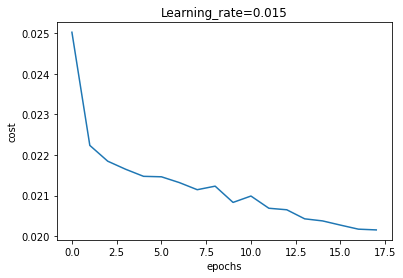

In [114]:
parameters=model(X_train,Y_train,layer_dims,learning_rate=0.015,num_epochs=18,mini_batch_size=32,print_cost=True,plot=True)

In [115]:
def predict(X,Y,parameters):
  
  m = X.shape[1]
  n = len(parameters) // 2 
  p = np.zeros((1,m))

  probability,caches=forward_prop(X,parameters)
  for i in range (0,probability.shape[1]):
    if probability[0,i]>=0.5:
      p[0,i]=1
    else:
      p[0,i]=0
  print("Accuracy: "  + str(np.mean((p[0,:] == Y[0,:]))))
  return p

In [116]:
predict_train=predict(X_train,Y_train,parameters)

Accuracy: 0.6782894736842106


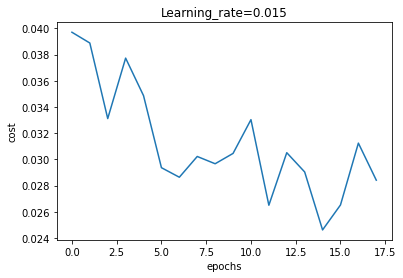

Accuracy: 0.85


In [117]:
parameters_val=model(X_val,Y_val,layer_dims,learning_rate=0.015,num_epochs=18,mini_batch_size=32,print_cost=False,plot=True)
predict_test=predict(X_val,Y_val,parameters_val)

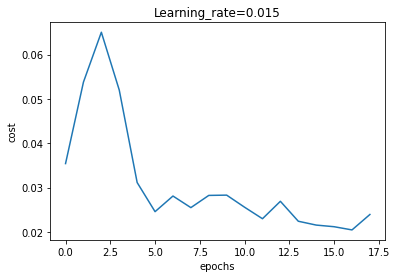

Accuracy: 0.875


In [118]:
parameters_test=model(X_test,Y_test,layer_dims,learning_rate=0.015,num_epochs=18,mini_batch_size=32,print_cost=False,plot=True)
predict_test=predict(X_test,Y_test,parameters_test)